In [1]:
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('labelled.csv').iloc[:,0:2]
data

,sentence,label
0,The buses didn't start arriving until almost 7...,O
1,"visit the visitors center , lots of informatio...",T
2,"And if you are looking for a w.c., one good pl...",T
3,Impressive and absolutely gorgeous.,E
4,They told me on the phone that I should have b...,O
...,...,...
1995,".This park is huge, beautiful and well kept.",E
1996,I booked a timed slot.,O
1997,".As for the so called 'free pint' , the Gravit...",O
1998,.The staff is amazing courteous kind everyone ...,E


In [3]:
data['sentence'].iloc[0]

"The buses didn't start arriving until almost 7:30 and by that time the line is long."

In [4]:
X, y = data['sentence'], data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

Text(0, 0.5, 'Count')

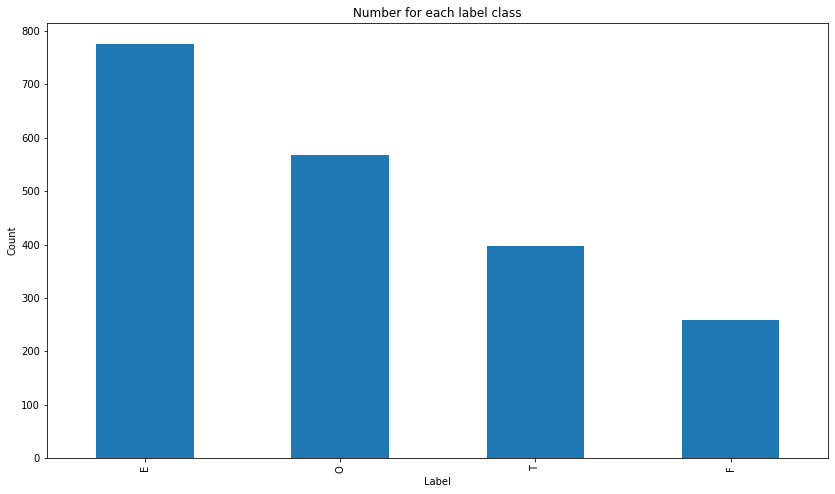

In [6]:
import matplotlib.pyplot as plt
ax = data['label'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for each label class")
ax.set_xlabel("Label")
ax.set_ylabel("Count")

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(data['sentence']).toarray()
labels = data.label
features.shape

(2000, 676)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data['sentence'], data['label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [11]:
print(clf.predict(count_vect.transform(['Also, its absolutely no bags in the crown, not even little ones, so you have to use the lockers anyways.'])))

['E']


/Users/yuconghu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/yuconghu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/yuconghu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/yuconghu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/yuconghu/anaconda3/lib/python3.7/site-packages/sklearn/

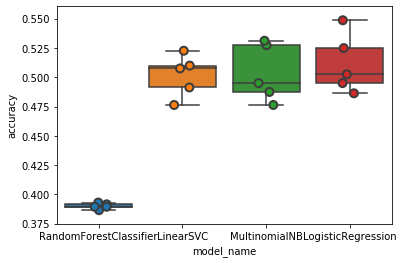

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    ]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
        
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

## Finding chi square correlation of bag of words to classes

In [58]:
# DO NOT run yet - incomplete

from sklearn.feature_selection import chi2

data['label_id'] = data['label'].factorize()[0]
label_id_df = data[['label', 'label_id']].sort_values('label_id')
label_to_id = dict(label_id_df.values)
print (label_to_id)
N = 2
for Label, label_id in sorted((label_to_id).items()):
    features_chi2 = chi2(features, labels == label_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print("# '{}':".format(Label))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

{'F': 0, 'T': 1, 'E': 2, 'O': 3}
# 'E':
  . Most correlated unigrams:
. gave
. zoo
  . Most correlated bigrams:
. good time
. gift shop
  . Most correlated trigrams:
. san diego zoo
# 'F':
  . Most correlated unigrams:
. gave
. zoo
  . Most correlated bigrams:
. good time
. gift shop
  . Most correlated trigrams:
. san diego zoo
# 'O':
  . Most correlated unigrams:
. gave
. zoo
  . Most correlated bigrams:
. good time
. gift shop
  . Most correlated trigrams:
. san diego zoo
# 'T':
  . Most correlated unigrams:
. gave
. zoo
  . Most correlated bigrams:
. good time
. gift shop
  . Most correlated trigrams:
. san diego zoo
